In [1]:
# exploring options to optimise particle filter params
# by optimising for accuracy over realworld log

# log was taken using nav-stack to drive around the office, and intermittently logging ground truth poses manually
# throughout the run

In [2]:
from typing import List
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from cbl_particle_filter.filter import load_input_log
from cbl_particle_filter.carpet_map import load_map_from_png
from cbl_particle_filter.filter import Pose, CarpetBasedParticleFilter, offline_playback
from cbl_particle_filter.visualisation import plot_map

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [3]:
log_dir = Path("../logs/20210702_office_patrol_two_loops/").resolve()
log_file = f"{log_dir}/localiser_input_log.pickle"
map_png = f"{log_dir}/office_map.png"

In [4]:
carpet = load_map_from_png(map_png, cell_size=0.5)

In [5]:
log = load_input_log(log_file)
start_pose = log[1][2]
print(start_pose)
log

Pose(x=4.97748327255249, y=5.514139652252197, heading=1.5305780172348025)


[(OdomMeasurement(dx=0, dy=0, dheading=0),
  Color(index=3, name='DARK_BLUE', rgb=(0, 51, 204)),
  None),
 (None,
  None,
  Pose(x=4.97748327255249, y=5.514139652252197, heading=1.5305780172348025)),
 (OdomMeasurement(dx=0, dy=0, dheading=0),
  Color(index=1, name='LIGHT_BLUE', rgb=(51, 204, 255)),
  None),
 (OdomMeasurement(dx=0.03522510826587677, dy=-0.0024673750158399343, dheading=-0.13431528210639954),
  Color(index=1, name='LIGHT_BLUE', rgb=(51, 204, 255)),
  None),
 (OdomMeasurement(dx=0.04702814955174581, dy=-0.0026402838460591683, dheading=-0.10972237586975098),
  Color(index=1, name='LIGHT_BLUE', rgb=(51, 204, 255)),
  None),
 (OdomMeasurement(dx=0.08271735404162345, dy=-0.004920387848441822, dheading=-0.14188212156295776),
  Color(index=1, name='LIGHT_BLUE', rgb=(51, 204, 255)),
  None),
 (OdomMeasurement(dx=0.07579428483031608, dy=-0.005343625216320841, dheading=-0.11350572109222412),
  Color(index=1, name='LIGHT_BLUE', rgb=(51, 204, 255)),
  None),
 (OdomMeasurement(dx=0.22

In [6]:
last_i = 0
for i, record in enumerate(log):
    if record[0] is None:
        print(f"{i}, diff\t{i-last_i}\t{record[2]}")
        last_i = i
        

1, diff	1	Pose(x=4.97748327255249, y=5.514139652252197, heading=1.5305780172348025)
87, diff	86	Pose(x=18.794843673706055, y=12.889660835266113, heading=0.02972614206373692)
180, diff	93	Pose(x=28.18488311767578, y=12.242392539978027, heading=-1.5702815055847168)
312, diff	132	Pose(x=43.2259407043457, y=14.831512451171875, heading=-1.612712383270264)
390, diff	78	Pose(x=34.75948715209961, y=9.74599838256836, heading=3.10703444480896)
456, diff	66	Pose(x=23.80694580078125, y=12.845460891723633, heading=3.117488145828247)
647, diff	191	Pose(x=5.0482378005981445, y=5.660976886749268, heading=1.6402602195739748)
754, diff	107	Pose(x=23.449460983276367, y=13.051251411437988, heading=-0.05645184591412544)
835, diff	81	Pose(x=36.69599914550781, y=10.288532257080078, heading=0.14155556261539462)
907, diff	72	Pose(x=43.18238830566406, y=14.834230422973633, heading=-1.5915615558624265)
981, diff	74	Pose(x=34.31340026855469, y=9.834495544433594, heading=-3.1049394607543945)
1040, diff	59	Pose(x=2

In [7]:
def perform_playback(
    log,
    carpet_map,
    seed_pose,
    pf_params=dict(),
    ):
    """
    Localise over given log, returning a dataframe of localised poses and
    ground truth
    """
    
    np.random.seed(123)
    
    localised_poses = offline_playback(
        input_data = log,
        carpet = carpet,
        seed_pose = seed_pose,
        use_seed_messages=False,
        **pf_params,
    )    
    
    # convert results to dataframe
    ground_truth_poses = [gt_pose for _, _, gt_pose in log]

    df_data = []
    for ground_truth_pose, localised_pose in zip(ground_truth_poses, localised_poses):
        if ground_truth_pose:
            gt_x = ground_truth_pose.x
            gt_y = ground_truth_pose.y
        else:
            gt_x = float("nan")
            gt_y = float("nan")
            
        df_data.append({
            "gt_x":gt_x,
            "gt_y":gt_y,
            "loc_x":localised_pose.x,
            "loc_y":localised_pose.y,
        })
    return pd.DataFrame(df_data)

def plot_results(results_df:pd.DataFrame):    
    fig, ax = plt.subplots()
    plot_map(carpet, show=False)
    plt.plot(results_df.loc_x, results_df.loc_y, color='tab:green', marker='o',markersize=3)
    plt.plot(results_df.gt_x, results_df.gt_y, color='tab:orange', marker='o', linewidth=2)
    
    lines = [((row.loc_x, row.loc_y), (row.gt_x, row.gt_y)) for _, row in results_df.iterrows()]
    lc = mc.LineCollection(lines, colors="red")
    ax.add_collection(lc)

    plt.axis('off')
    plt.legend(['ground truth', 'particle filter output'])
    plt.show()
    
def get_playback_error(
    log,
    carpet_map,
    seed_pose,
    plot=False,
    print_inidividual_errors=False,
    pf_params=dict()
    ):
    """
    Report sum squared position error for playback of the given log
    """
    results_df = perform_playback(
        log,
        carpet_map,
        seed_pose,
        pf_params=pf_params,
    )
    ground_truth_results = results_df[~np.isnan(results_df.gt_x)].copy()
    ground_truth_results.loc[:,"position_error"] = np.linalg.norm(
        np.vstack(
            [
                ground_truth_results.loc_x - ground_truth_results.gt_x,
                ground_truth_results.loc_y - ground_truth_results.gt_y
            ]
        ),axis=0
    )
    if print_inidividual_errors:
        print(ground_truth_results)
        
    sum_squared_error = sum(np.power(ground_truth_results["position_error"],2))
    
    if plot:
        plot_results(results_df)

    return sum_squared_error

In [8]:
# The next few cells explore different values for odom_pos_noise
# Results indicate lower values are better

           gt_x       gt_y      loc_x      loc_y  position_error
1      4.977483   5.514140   5.158206   5.616755        0.207824
87    18.794844  12.889661  18.705978  12.809106        0.119942
180   28.184883  12.242393  27.816179  12.221072        0.369320
312   43.225941  14.831512  43.231452  14.881112        0.049905
390   34.759487   9.745998  34.788605   9.730119        0.033167
456   23.806946  12.845461  23.842483  12.734439        0.116570
647    5.048238   5.660977   5.008211   5.476340        0.188925
754   23.449461  13.051251  23.386255  12.940041        0.127917
835   36.695999  10.288532  36.755144   9.880837        0.411963
907   43.182388  14.834230  43.580679  14.323268        0.647857
981   34.313400   9.834496  34.414153   9.742093        0.136709
1040  23.324804  12.799183  23.353274  12.713585        0.090208
1150   5.016664   5.521140   5.018635   5.502961        0.018285


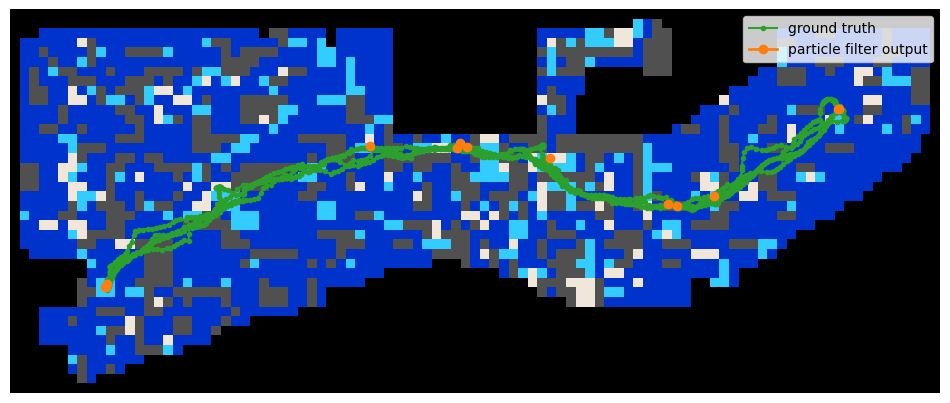

0.8798022466255815

In [9]:
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    plot=True,
    print_inidividual_errors=True,
    pf_params=dict(
        resample_proportion=0,
        weight_fn_p=0.9,
        odom_pos_noise=0.05,
        odom_heading_noise=0.05,
        n_particles=500,
    ),
)

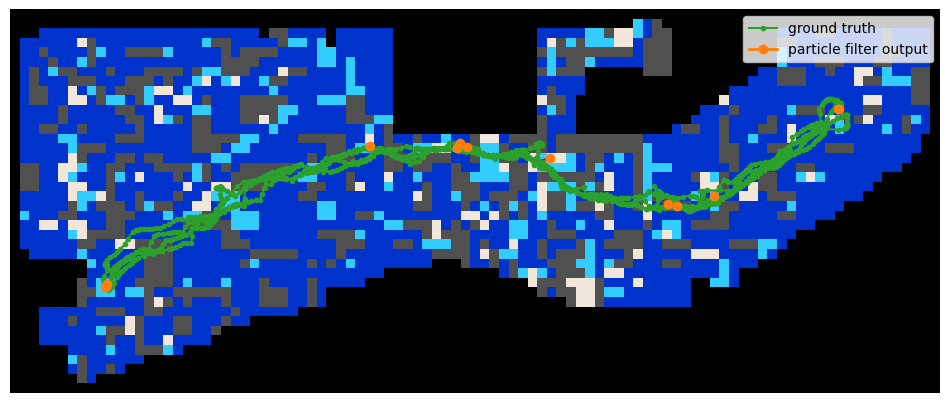

2.267564356449735

In [10]:
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    plot=True,
    pf_params=dict(
        resample_proportion=0,
        weight_fn_p=0.9,
        odom_pos_noise=0.1,
        odom_heading_noise=0.05,
        n_particles=500,
    )
)

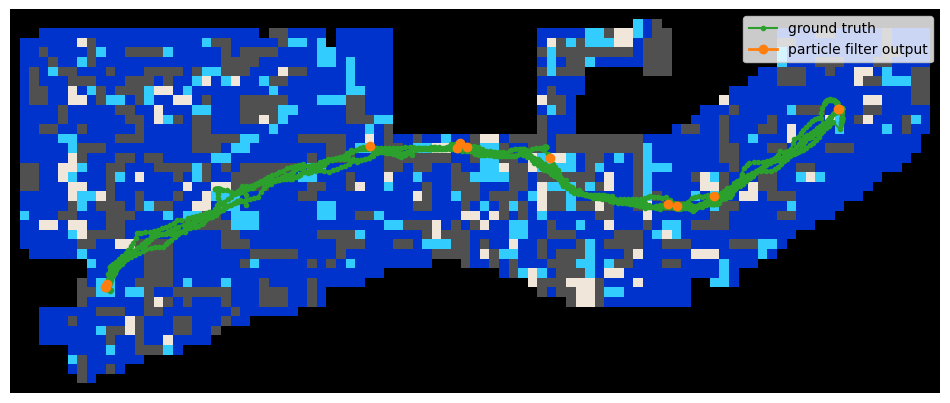

0.6166064443255475

In [11]:
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    plot=True,
    pf_params=dict(
        resample_proportion=0,
        weight_fn_p=0.9,
        odom_pos_noise=0.01,
        odom_heading_noise=0.05,
        n_particles=500,
    ),
)

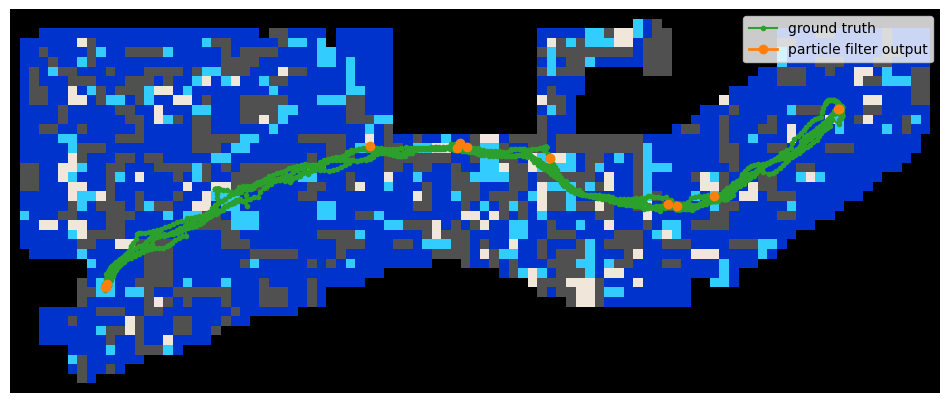

0.44456570819082863

In [12]:
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    plot=True,
    pf_params=dict(
        resample_proportion=0,
        weight_fn_p=0.9,
        odom_pos_noise=0.0,
        odom_heading_noise=0.05,
        n_particles=500,
    )
)

In [13]:
# Try some parameter value sweeps to look for minima in a more automated fashion

In [14]:
def test_parameter_range(parameter_name:str, parameter_values:List, default_params:dict=dict()):
    print("default params:")
    param_print(default_params)
    print()
    for parameter_value in parameter_values:
        pf_params = default_params.copy()
        pf_params.update({parameter_name:parameter_value})
        error = get_playback_error(
            log,
            carpet,
            seed_pose=start_pose,
            plot=False,
            pf_params=pf_params,        
        )
        print(f"{parameter_name}={parameter_value},\t{error=}")
                         
default_params = dict(
    resample_proportion=0,
    weight_fn_p=0.9,
    odom_pos_noise=0.0,
    odom_heading_noise=0.05,
    n_particles=500,
)

def param_print(params:dict):
    for k,v in params.items():
        print(f"  {k}={v}")

In [15]:
test_parameter_range("odom_pos_noise",[0, 0.005, 0.01, 0.02, 0.1, 1.0], default_params)

default params:
  resample_proportion=0
  weight_fn_p=0.9
  odom_pos_noise=0.0
  odom_heading_noise=0.05
  n_particles=500

odom_pos_noise=0,	error=0.44456570819082863
odom_pos_noise=0.005,	error=1.2359871315685156
odom_pos_noise=0.01,	error=0.6166064443255475
odom_pos_noise=0.02,	error=0.5530135287383883
odom_pos_noise=0.1,	error=2.267564356449735
odom_pos_noise=1.0,	error=3282.085498661816


In [16]:
# the best value was achieved at odom_pos_noise=0, although, I'd be a bit more comfortable
# using 0.01 or 0.02, as this more closely matches reality (there is some noise)

# Conclusion - further test odom_pos_noise=0
default_params['odom_pos_noise'] = 0.0

In [17]:
test_parameter_range("odom_heading_noise",[0, 0.005, 0.01, 0.05, 0.1, 1.0], default_params)

default params:
  resample_proportion=0
  weight_fn_p=0.9
  odom_pos_noise=0.0
  odom_heading_noise=0.05
  n_particles=500

odom_heading_noise=0,	error=4801.478450161107
odom_heading_noise=0.005,	error=4527.205180480016
odom_heading_noise=0.01,	error=4863.878455422644
odom_heading_noise=0.05,	error=0.44456570819082863
odom_heading_noise=0.1,	error=5.4242795401812005
odom_heading_noise=1.0,	error=7236.389292228416


In [18]:
# odom_heading_noise looks good around 0.05, with much larger errors either side
# -> do some more focussed tests

In [19]:
test_parameter_range("odom_heading_noise",np.linspace(0.0, 0.1, 9), default_params)

default params:
  resample_proportion=0
  weight_fn_p=0.9
  odom_pos_noise=0.0
  odom_heading_noise=0.05
  n_particles=500

odom_heading_noise=0.0,	error=4801.478450161107
odom_heading_noise=0.0125,	error=3629.3516529512017
odom_heading_noise=0.025,	error=0.4091937499200477
odom_heading_noise=0.037500000000000006,	error=0.4879871034318715
odom_heading_noise=0.05,	error=0.44456570819082863
odom_heading_noise=0.0625,	error=1.3459394037041683
odom_heading_noise=0.07500000000000001,	error=3.2798906149074947
odom_heading_noise=0.08750000000000001,	error=4.159012581009489
odom_heading_noise=0.1,	error=5.4242795401812005


In [20]:
# Conclusion - some local minima, but best result at 0.025
default_params['odom_heading_noise'] = 0.025

In [21]:
test_parameter_range("resample_proportion",[0, 0.01, 0.1, 1.0], default_params)

default params:
  resample_proportion=0
  weight_fn_p=0.9
  odom_pos_noise=0.0
  odom_heading_noise=0.025
  n_particles=500

resample_proportion=0,	error=0.4091937499200477
resample_proportion=0.01,	error=918.7651897036659
resample_proportion=0.1,	error=2296.9412417617573
resample_proportion=1.0,	error=2215.153634328959


In [22]:
# resample proportion doesn't appear to help at all.
# My assumption would be that this resampling increases the chance of recovering from loss of localisation,
# at the expense of degrading accuracy in the normal case.

# Conclusion - keep using resample_proportion=0

In [23]:
test_parameter_range("weight_fn_p",[0.5, 0.8, 0.9, 0.95, 0.99, 1.0], default_params)

default params:
  resample_proportion=0
  weight_fn_p=0.9
  odom_pos_noise=0.0
  odom_heading_noise=0.025
  n_particles=500

weight_fn_p=0.5,	error=3796.125499506484
weight_fn_p=0.8,	error=0.49921166760641683
weight_fn_p=0.9,	error=0.4091937499200477
weight_fn_p=0.95,	error=0.48154254546887787
weight_fn_p=0.99,	error=0.5058855322483647


/home/tfanselo/projects/personal/20210106_cbl/carpet_localisation/venv/lib/python3.8/site-packages/pfilter/pfilter.py:347: RuntimeWarning: divide by zero encountered in log
  self.weight_entropy = np.sum(self.weights * np.log(self.weights))
/home/tfanselo/projects/personal/20210106_cbl/carpet_localisation/venv/lib/python3.8/site-packages/pfilter/pfilter.py:347: RuntimeWarning: invalid value encountered in multiply
  self.weight_entropy = np.sum(self.weights * np.log(self.weights))
/home/tfanselo/projects/personal/20210106_cbl/carpet_localisation/venv/lib/python3.8/site-packages/pfilter/pfilter.py:342: RuntimeWarning: invalid value encountered in true_divide
  self.weights = weights / self.weight_normalisation


weight_fn_p=1.0,	error=nan


In [24]:
# Conclusion - use weight_fn_p=0.9
default_params['weight_fn_p'] = 0.9

In [25]:
test_parameter_range("n_particles",[10, 100, 1000, 10000], default_params)

default params:
  resample_proportion=0
  weight_fn_p=0.9
  odom_pos_noise=0.0
  odom_heading_noise=0.025
  n_particles=500

n_particles=10,	error=4145.72934984468
n_particles=100,	error=0.8260973630421247
n_particles=1000,	error=0.468091594139441
n_particles=10000,	error=0.41906271852587423


In [26]:
# More particles = better, but 10k is pretty slow to run. 


In [27]:
# more focused particle number testing
test_parameter_range("n_particles",[100, 200, 300, 500, 700, 1000], default_params)

default params:
  resample_proportion=0
  weight_fn_p=0.9
  odom_pos_noise=0.0
  odom_heading_noise=0.025
  n_particles=500

n_particles=100,	error=0.8260973630421247
n_particles=200,	error=0.5816041827684891
n_particles=300,	error=0.49181064735154334
n_particles=500,	error=0.4091937499200477
n_particles=700,	error=0.4994570162681814
n_particles=1000,	error=0.468091594139441


In [28]:
# anything over 100 does not appear to have a large effect on error, although I'd still want to keep the number
# high for general robustness (don't want to overfit this limited dataset)

# Received best results with n=500, so will stick with that

# Conclusion - use n_particles=500
default_params['n_particles'] = 500

Best guess params:
  resample_proportion=0
  weight_fn_p=0.9
  odom_pos_noise=0.0
  odom_heading_noise=0.025
  n_particles=500


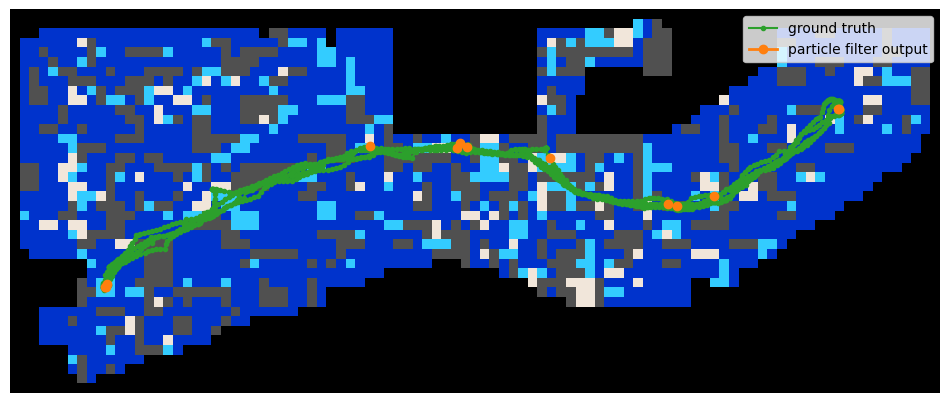

0.4091937499200477

In [29]:
# current best guess
print("Best guess params:")
param_print(default_params)
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    plot=True,
    pf_params=default_params
)

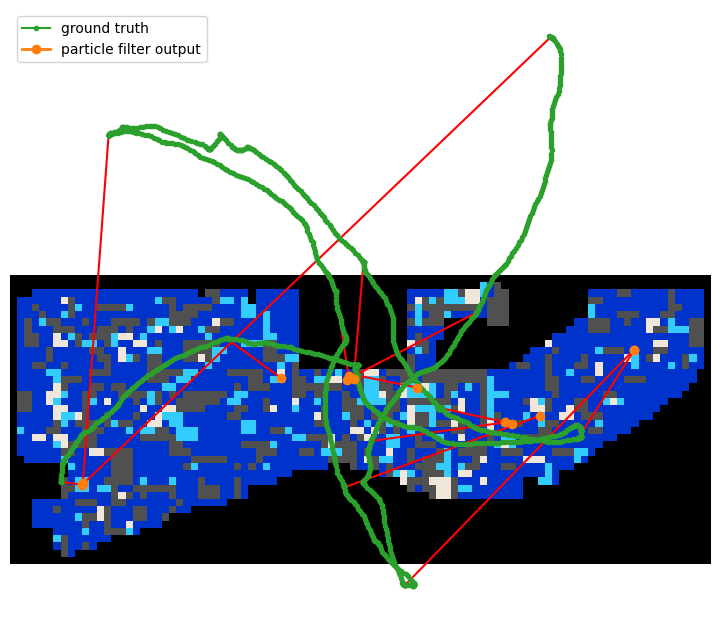

3733.8097406045426

In [30]:
# Try odom only

# use slightly different heading, to make dead reckoning line up with actual trajectory 
# a little better
odom_seed = Pose(x=start_pose.x, y=start_pose.y, heading=start_pose.heading + np.pi/180*30)

get_playback_error(
        log,
        carpet,
        seed_pose=odom_seed,
        plot=True,
        pf_params=dict(
            odom_pos_noise=0.0,
            odom_heading_noise=0.0,
            resample_proportion=0,
            weight_fn_p = 0.5,
            n_particles = 2
        )
    )

In [31]:
# not awful, but a fair amount of angular drift over time. Also some amount of scale error